In [57]:
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime
from matplotlib import pyplot as plt
from scipy.stats import ttest_ind, mannwhitneyu

In [ ]:
Импорт и анализ таблиц

In [58]:
df_orders = pd.read_excel('Новый диплом датасет.xlsx', sheet_name = 'Данные')
df_clients = pd.read_excel('Новый диплом датасет.xlsx', sheet_name = 'Clients')
df_reg = pd.read_excel('Новый диплом датасет.xlsx', sheet_name = 'Region_dict')

In [59]:
df_orders.head()

,id_order,id_client,amt_payment,dtime_pay
0,100238,194569.0,5373.0,2022-10-28 04:05:15.221000
1,100242,191056.0,4151.0,2022-08-01 02:42:54.992000
2,100249,200049.0,5688.0,2022-08-24 12:45:12.744000
3,100258,206161.0,4330.0,2022-12-09 15:13:26.437000
4,100267,190945.0,5488.0,2022-08-03 02:07:31.468000


In [60]:
df_orders.isnull().any()

id_order       False
id_client       True
amt_payment     True
dtime_pay       True
dtype: bool

In [61]:
print(len(df_orders[df_orders['id_client'].isnull()]))
print(len(df_orders[df_orders['amt_payment'].isnull()]))
print(len(df_orders[df_orders['dtime_pay'].isnull()]))

588
2144
2161


In [62]:
df_orders = df_orders[~((df_orders['id_client'].isnull()) | (df_orders['amt_payment'].isnull()) | (df_orders['dtime_pay'].isnull()))]

In [63]:
df_clients['dtime_ad'] = df_clients['dtime_ad'].apply(pd.Timestamp)

In [64]:
df_clients.head()

,id_client,dtime_ad,nflag_test,id_trading_point
0,180844,2022-06-08 18:38:41.414,0,212
1,193942,NaT,0,13
2,226069,2022-07-11 16:28:38.511,1,54
3,183981,2022-06-16 12:23:59.289,1,991
4,322530,2022-07-08 08:56:08.714,0,1015


In [65]:
df_clients.isnull().any()

id_client           False
dtime_ad             True
nflag_test          False
id_trading_point    False
dtype: bool

In [66]:
print(len(df_clients))
print(len(df_clients[df_clients['dtime_ad'].isnull()]))

55605
249


In [67]:
df_clients = df_clients[~df_clients['dtime_ad'].isnull()]

In [68]:
print(len(df_clients))

55356


In [69]:
df_reg.head()

,id_trading_point,city
0,1,Петрозаводск
1,2,Дмитров
2,4,Чехов
3,7,Ростов Великий
4,11,Владимир


In [70]:
df_reg_gr = df_reg.groupby('city').count()['id_trading_point'].reset_index().sort_values(by = 'id_trading_point', ascending = False)

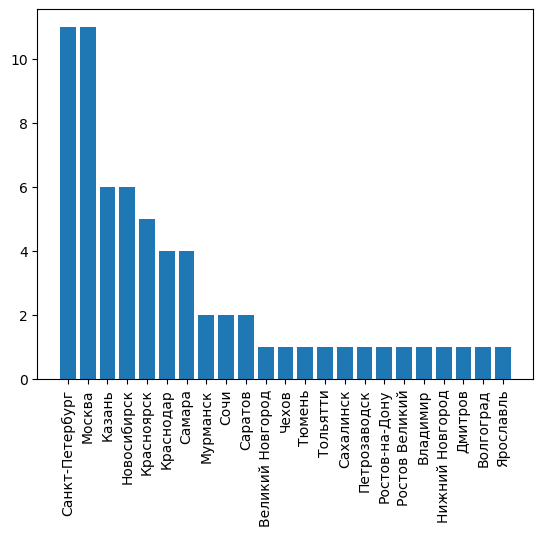

In [71]:
plt.bar(df_reg_gr['city'], df_reg_gr['id_trading_point'])
plt.xticks(rotation = 90)
plt.show()

In [72]:
df_reg.isnull().any()

id_trading_point    False
city                False
dtype: bool

In [ ]:
Объединение таблиц

In [73]:
print(len(df_clients))
print(df_clients.nunique()['id_client'])

55356
55356


In [74]:
df = df_orders.merge(df_clients, on = 'id_client', how = 'outer')
df = df.merge(df_reg, on = 'id_trading_point')

In [75]:
df['amt_payment'] = df['amt_payment'].fillna(0)

In [76]:
df_cl = df.groupby(['id_client','id_trading_point','city']).agg({'id_order':'count', 'amt_payment':'sum'}).reset_index()

In [77]:
df_fin = df_cl.merge(df_clients[['id_client','nflag_test']], on = 'id_client')

In [78]:
df_fin['nflag_paid'] = np.where(df_fin['amt_payment'] > 0, 1, 0)

In [80]:
df_fin.groupby('city').nunique()['id_trading_point'].reset_index().sort_values('id_trading_point', ascending = False).head()

,city,id_trading_point
15,Санкт-Петербург,11
7,Москва,11
4,Казань,6
10,Новосибирск,6
6,Красноярск,5


In [ ]:
Чистка неверно заполненных точек

In [81]:
zero_payment_points = []

for i in df_fin['id_trading_point'].unique():
    
    df_loc = df_fin[df_fin['id_trading_point']==i]
    sum_a = df_fin[(df_fin['id_trading_point']==i) & (df_fin['nflag_test']==0)].sum()['amt_payment']
    sum_b = df_fin[(df_fin['id_trading_point']==i) & (df_fin['nflag_test']==1)].sum()['amt_payment']
    if (sum_a == 0) | (sum_b == 0):
        zero_payment_points.append(i)
        
print(zero_payment_points)

[26.0, 739.0, 866.0, 46.0, 1099.0, 1015.0, 603.0, 810.0, 800.0, 228.0, 1.0, 13.0, 23.0, 4.0, 7.0]


In [82]:
empty_group_points = []

for i in df_fin['id_trading_point'].unique():
    
    c_a = df_fin[(df_fin['id_trading_point']==i) & (df_fin['nflag_test']==0)].count()['id_client']
    c_b = df_fin[(df_fin['id_trading_point']==i) & (df_fin['nflag_test']==1)].count()['id_client']
    if (c_a == 0) | (c_b == 0):
        empty_group_points.append(i)
        
print(empty_group_points)

[739.0, 866.0, 1099.0, 1015.0, 603.0, 810.0, 800.0, 228.0]


In [83]:
df_fin[df_fin['city']=='Ярославль']

,id_client,id_trading_point,city,id_order,amt_payment,nflag_test,nflag_paid
17,178578.0,46.0,Ярославль,1,4192.0,0,1
40,178601.0,46.0,Ярославль,5,19467.0,0,1
84,178645.0,46.0,Ярославль,0,0.0,1,0
100,178662.0,46.0,Ярославль,1,5826.0,0,1
189,178752.0,46.0,Ярославль,0,0.0,1,0
...,...,...,...,...,...,...,...
55137,330948.0,46.0,Ярославль,0,0.0,1,0
55160,331056.0,46.0,Ярославль,0,0.0,0,0
55241,331447.0,46.0,Ярославль,0,0.0,0,0
55251,331502.0,46.0,Ярославль,0,0.0,0,0


In [ ]:
Автоматизация статистических вычислений

In [84]:
def test_calc(r1, r2, alpha = 0.05):
    s,p = ttest_ind(r1,r2)
    
    if p < alpha:
        print("Гиотеза H0 не подтверждается: средние не равны")
        print("Разница средних =", r1.mean()-r2.mean())
    else:
        print("Гипотеза H0 подтверждается: средние равны")
        print("Разница средних = 0")
        
    return s, p        

In [85]:
def mann_whitney_func(r1, r2, alpha=.05):
    s, p = mannwhitneyu(r1, r2)
    
    if p<alpha:
        print('Распределения не равны')
    else:
        print('Распределения равны')
        
    return s, p

In [ ]:
Расчет общих результатов АБ Теста

In [86]:
df_fin = df_fin[~df_fin['id_trading_point'].isin(empty_group_points + zero_payment_points)]

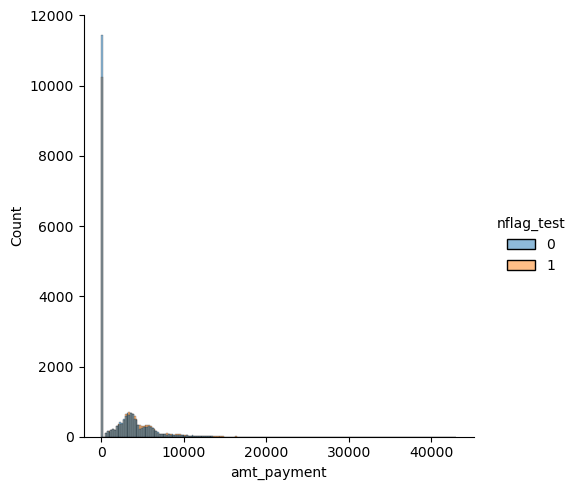

In [87]:
sns.displot(df_fin, x = 'amt_payment', hue = 'nflag_test')

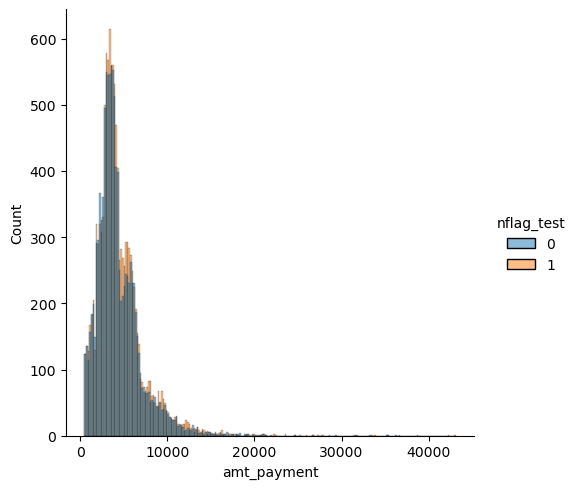

In [88]:
sns.displot(df_fin[df_fin['amt_payment'] > 0], x = 'amt_payment', hue = 'nflag_test')
plt.show()

In [89]:
test_calc(df_fin[df_fin['nflag_test']==1]['amt_payment'], df_fin[df_fin['nflag_test']==0]['amt_payment'])
          

Гиотеза H0 не подтверждается: средние не равны
Разница средних = 263.088912844727


(9.456798235171377, 3.3214645838934018e-21)

In [90]:
mann_whitney_func(df_fin[df_fin['nflag_test']==1]['amt_payment'], df_fin[df_fin['nflag_test']==0]['amt_payment'])

Распределения не равны


(270040116.0, 3.008345273971901e-24)

In [ ]:
Сегментация результатов АБ Теста

In [91]:
df_msk = df_fin[df_fin['city']=='Москва']

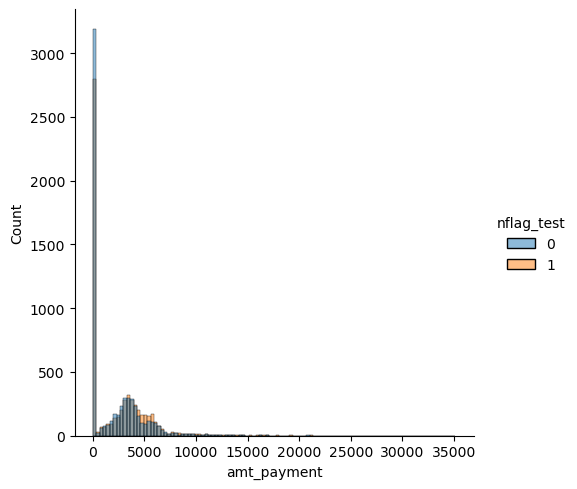

In [151]:
sns.displot(df_msk, x = 'amt_payment', hue = 'nflag_test')
plt.show()

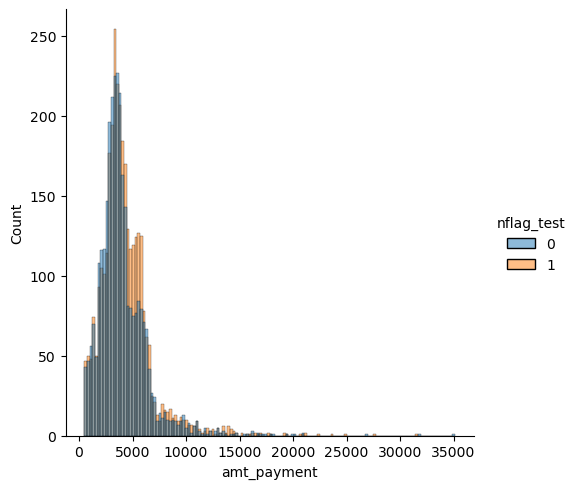

In [93]:
sns.displot(df_msk[df_msk['amt_payment'] > 0], x = 'amt_payment', hue = 'nflag_test')
plt.show()

In [94]:
print("t-test абсолютные платежи")
test_calc(df_msk[df_msk['nflag_test']==1]['amt_payment'], df_msk[df_msk['nflag_test']==0]['amt_payment'])
print()
print("t-test конверсия в платеж")
test_calc(df_msk[df_msk['nflag_test']==1]['nflag_paid'], df_msk[df_msk['nflag_test']==0]['nflag_paid'])
print()
print("Тест Манна-Уитни")
mann_whitney_func(df_msk[df_msk['nflag_test']==1]['amt_payment'], df_msk[df_msk['nflag_test']==0]['amt_payment'])

t-test абсолютные платежи
Гиотеза H0 не подтверждается: средние не равны
Разница средних = 381.7784892750842

t-test конверсия в платеж
Гиотеза H0 не подтверждается: средние не равны
Разница средних = 0.05557800593933432

Тест Манна-Уитни
Распределения не равны


(20595574.5, 7.010591402203484e-16)

In [95]:
df_spb = df_fin[df_fin['city']=='Санкт-Петербург']

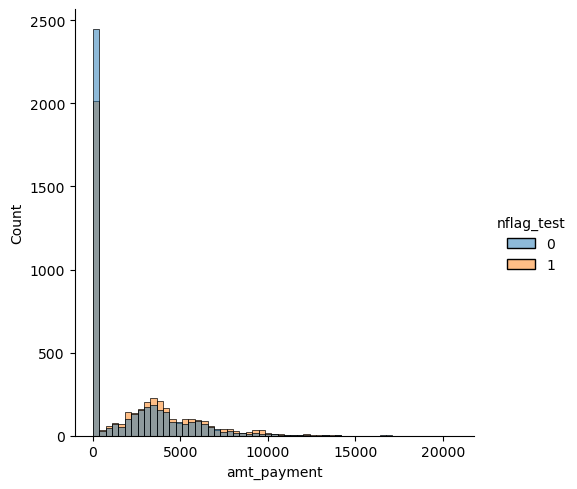

In [96]:
sns.displot(df_spb, x = 'amt_payment', hue = 'nflag_test')
plt.show()

In [97]:
print("t-test абсолютные платежи")
test_calc(df_spb[df_spb['nflag_test']==1]['amt_payment'], df_spb[df_spb['nflag_test']==0]['amt_payment'])
print()
print("t-test конверсия в платеж")
test_calc(df_spb[df_spb['nflag_test']==1]['nflag_paid'], df_spb[df_spb['nflag_test']==0]['nflag_paid'])
print()
print("Тест Манна-Уитни")
mann_whitney_func(df_spb[df_spb['nflag_test']==1]['amt_payment'], df_spb[df_spb['nflag_test']==0]['amt_payment'])

t-test абсолютные платежи
Гиотеза H0 не подтверждается: средние не равны
Разница средних = 513.9039043833998

t-test конверсия в платеж
Гиотеза H0 не подтверждается: средние не равны
Разница средних = 0.09877797751600403

Тест Манна-Уитни
Распределения не равны


(10899685.5, 2.0392184217953754e-20)

In [98]:
df_kaz = df_fin[df_fin['city']=='Казань']

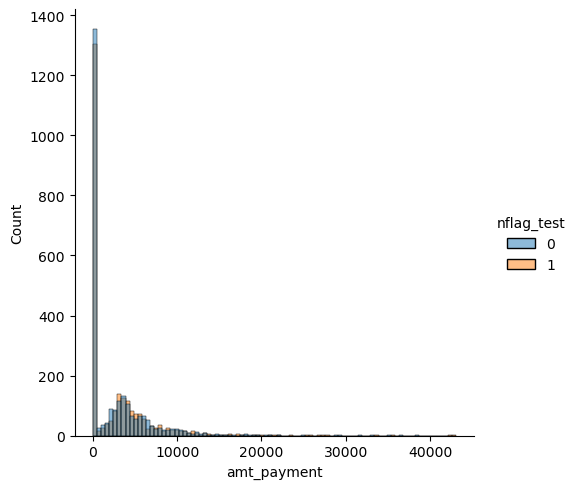

In [99]:
sns.displot(df_kaz, x = 'amt_payment', hue = 'nflag_test')

In [100]:
print("t-test абсолютные платежи")
test_calc(df_kaz[df_kaz['nflag_test']==1]['amt_payment'], df_kaz[df_kaz['nflag_test']==0]['amt_payment'])
print()
print("t-test конверсия в платеж")
test_calc(df_kaz[df_kaz['nflag_test']==1]['nflag_paid'], df_kaz[df_kaz['nflag_test']==0]['nflag_paid'])
print()
print("Тест Манна-Уитни")
mann_whitney_func(df_kaz[df_kaz['nflag_test']==1]['amt_payment'], df_kaz[df_kaz['nflag_test']==0]['amt_payment'])

t-test абсолютные платежи
Гипотеза H0 подтверждается: средние равны
Разница средних = 0

t-test конверсия в платеж
Гипотеза H0 подтверждается: средние равны
Разница средних = 0

Тест Манна-Уитни
Распределения равны


(3263925.0, 0.37726004167062477)

In [101]:
all_cities = list(df['city'].unique())
cities_big = ['Москва', 'Санкт-Петербург', 'Казань', 'Новосибирск']
other_cities = []

for i in all_cities:
    if i not in cities_big:
        other_cities.append(i)

Саратов



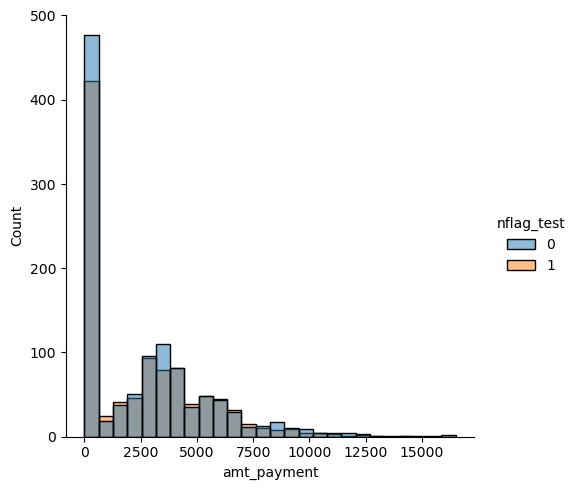

Гипотеза H0 подтверждается: средние равны
Разница средних = 0
Гипотеза H0 подтверждается: средние равны
Разница средних = 0
Номер торговой точки =  80.0


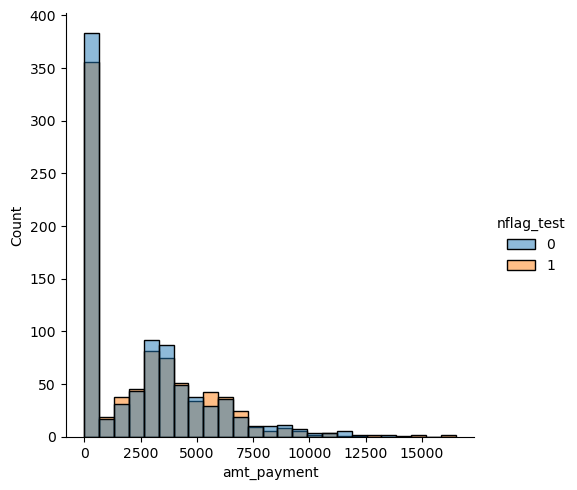

Номер торговой точки =  82.0


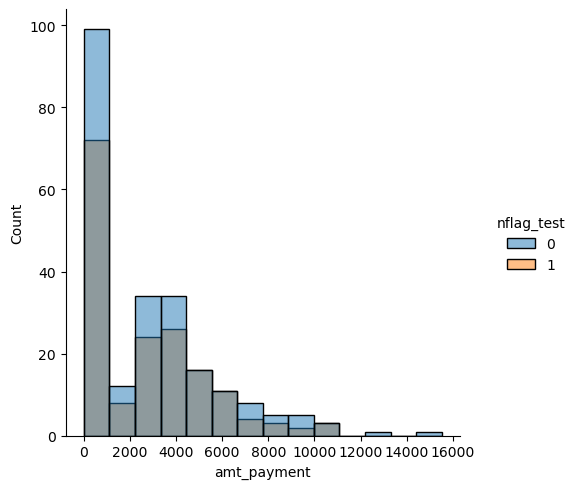

Красноярск



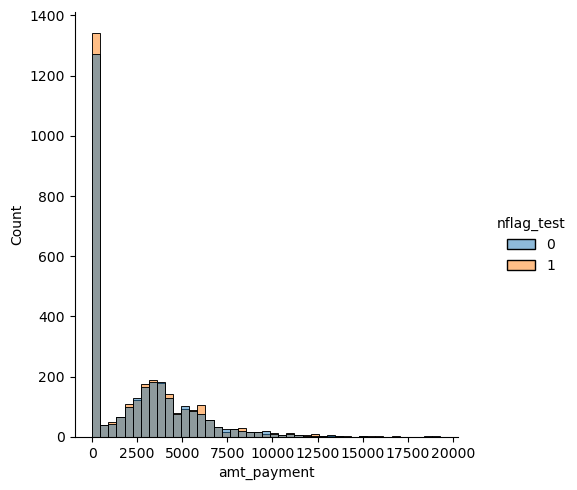

Гипотеза H0 подтверждается: средние равны
Разница средних = 0
Гипотеза H0 подтверждается: средние равны
Разница средних = 0
Номер торговой точки =  212.0


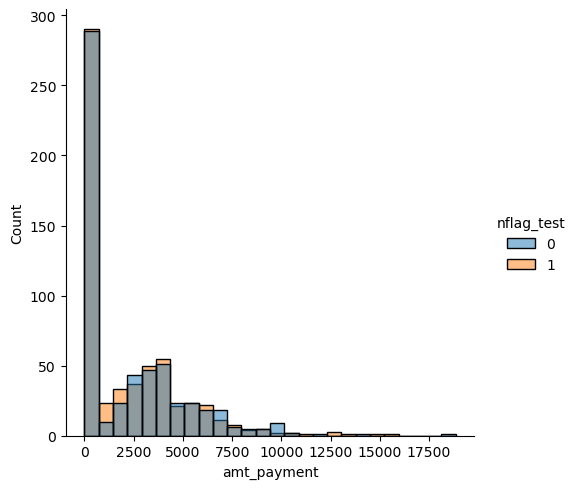

Номер торговой точки =  277.0


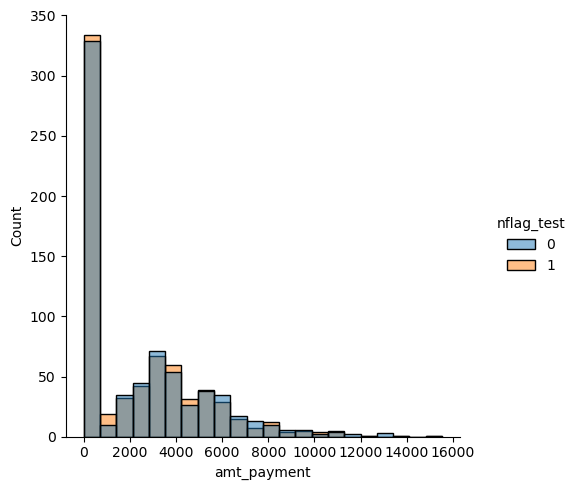

Номер торговой точки =  202.0


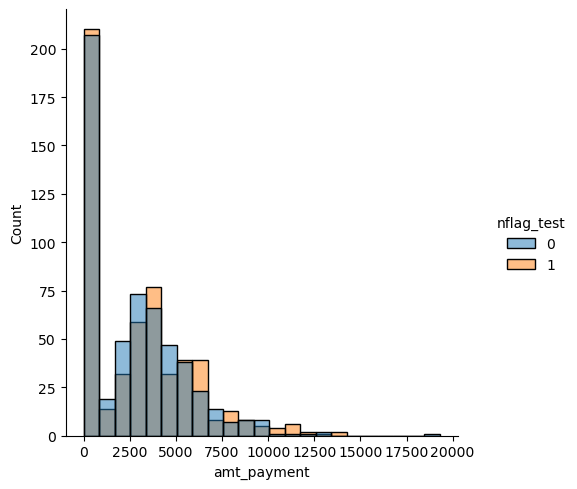

Номер торговой точки =  444.0


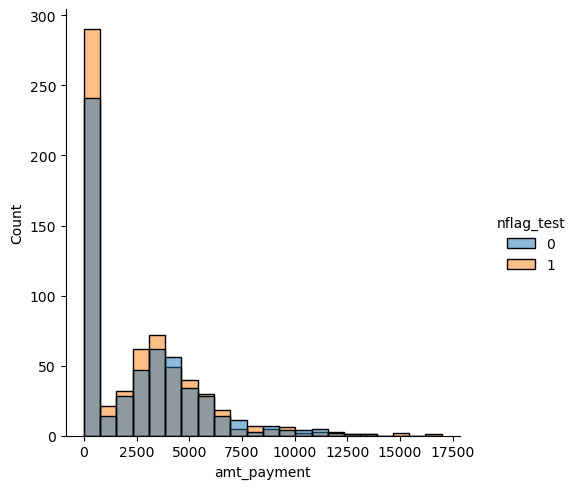

Номер торговой точки =  278.0


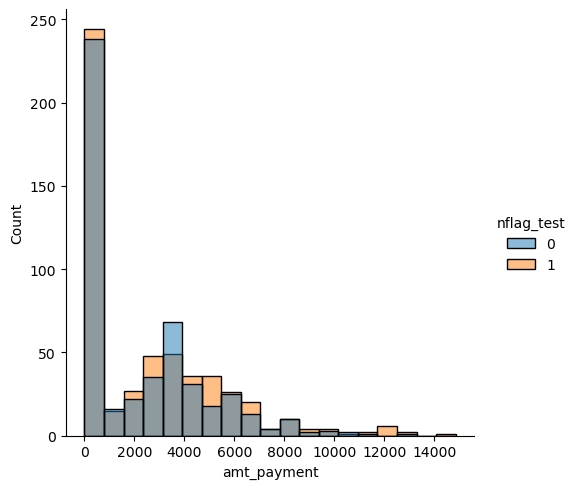

Самара



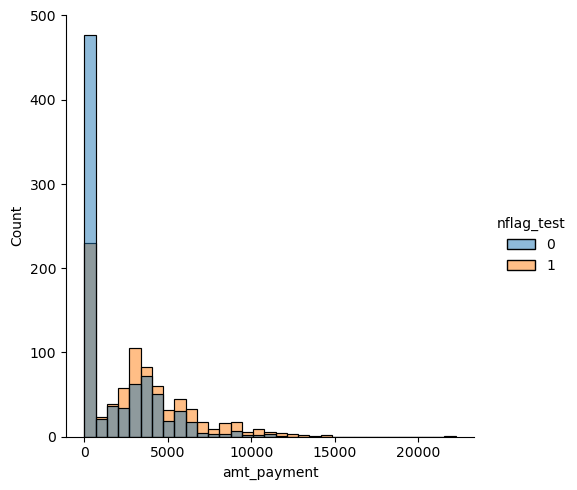

Гиотеза H0 не подтверждается: средние не равны
Разница средних = -1544.3720191247648
Гиотеза H0 не подтверждается: средние не равны
Разница средних = -0.2772412939282998
Номер торговой точки =  33.0


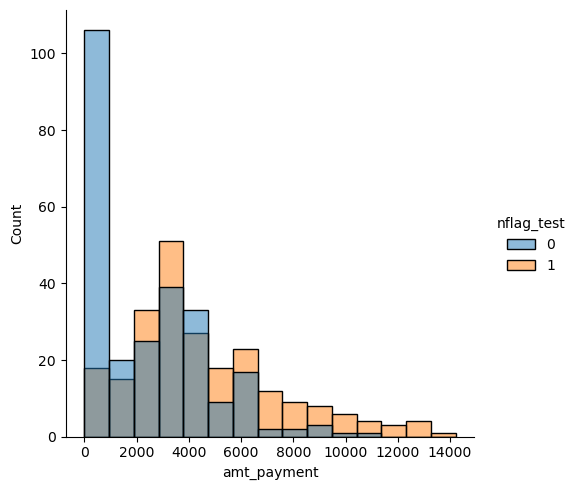

Номер торговой точки =  34.0


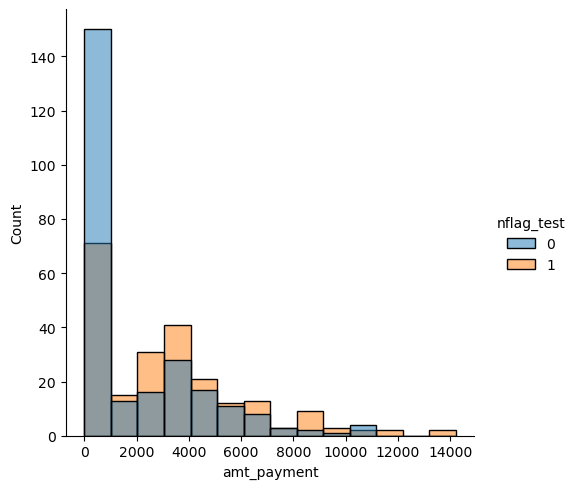

Номер торговой точки =  35.0


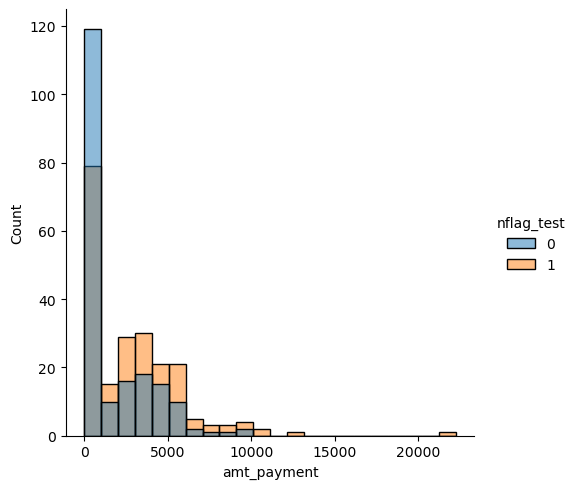

Номер торговой точки =  36.0


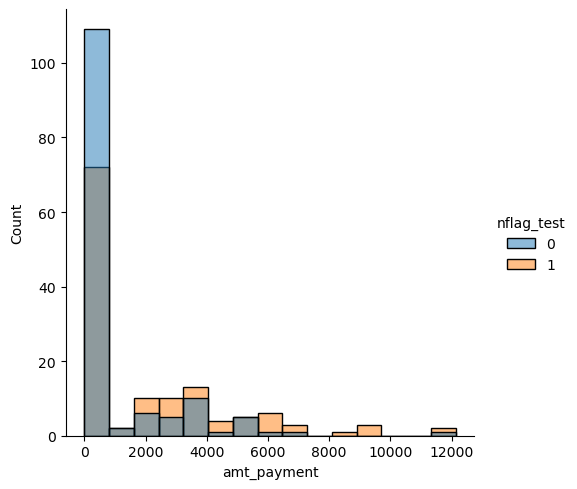

Краснодар



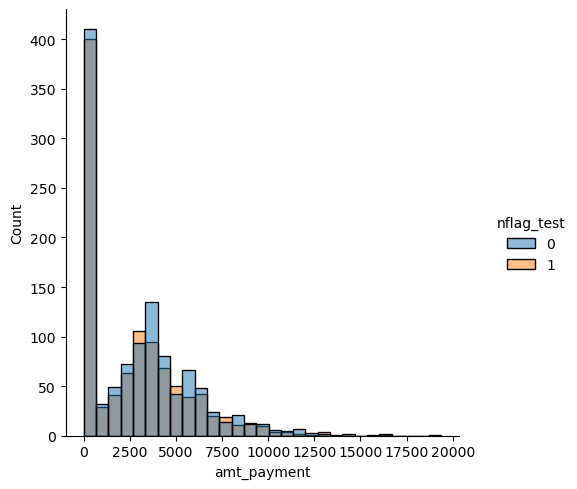

Гипотеза H0 подтверждается: средние равны
Разница средних = 0
Гипотеза H0 подтверждается: средние равны
Разница средних = 0
Номер торговой точки =  1101.0


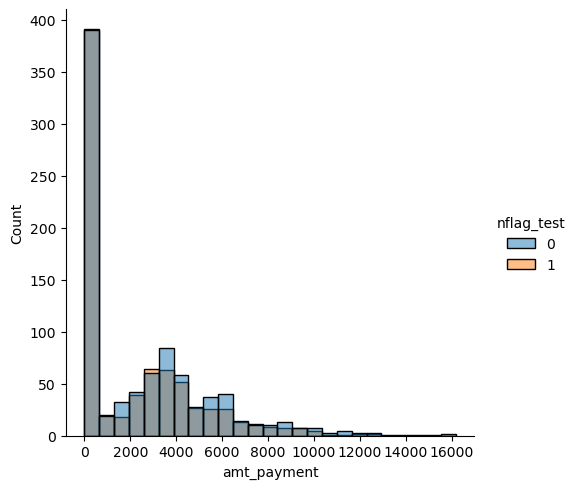

Номер торговой точки =  1989.0


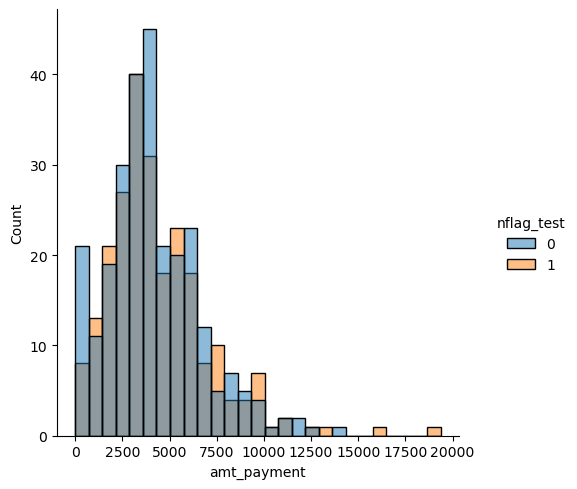

Мурманск



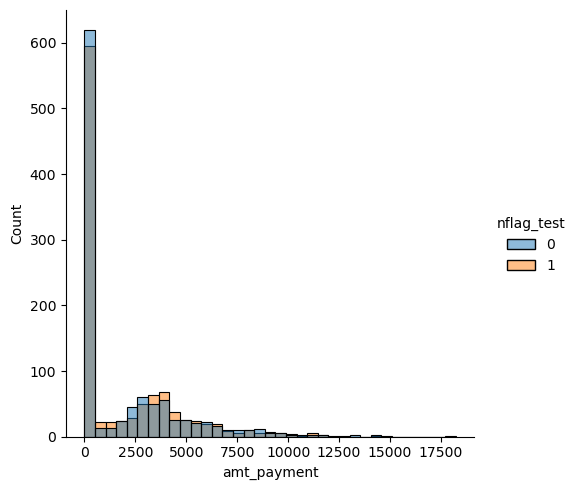

Гипотеза H0 подтверждается: средние равны
Разница средних = 0
Гипотеза H0 подтверждается: средние равны
Разница средних = 0
Номер торговой точки =  55.0


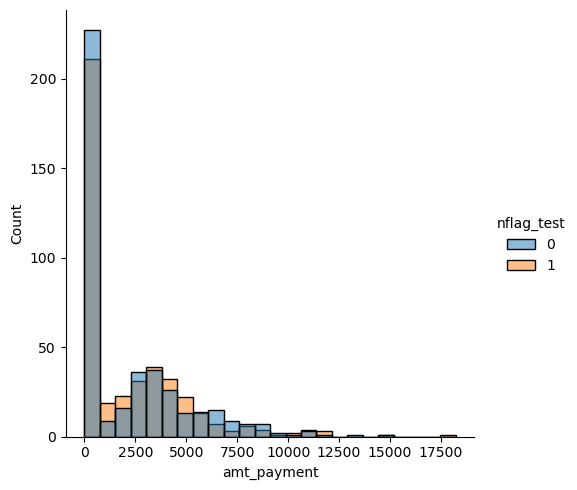

Номер торговой точки =  54.0


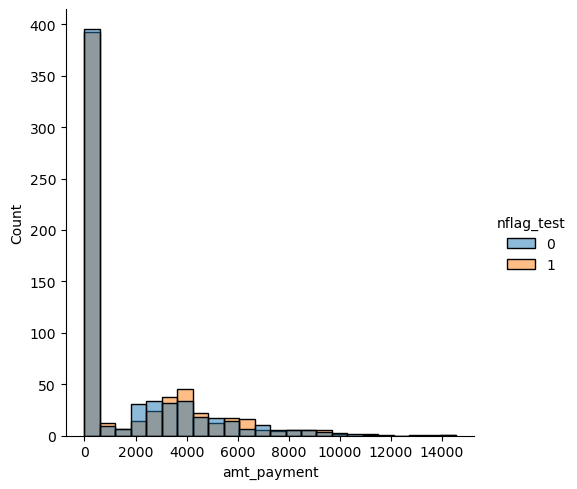

Владимир



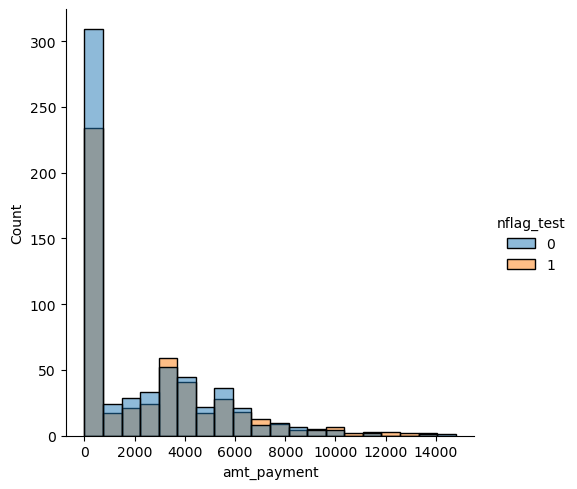

Гиотеза H0 не подтверждается: средние не равны
Разница средних = -438.6098419243094
Гипотеза H0 подтверждается: средние равны
Разница средних = 0
Номер торговой точки =  11.0


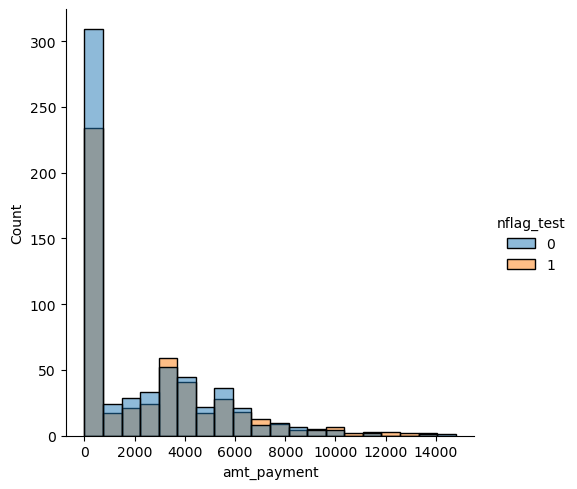

Сочи



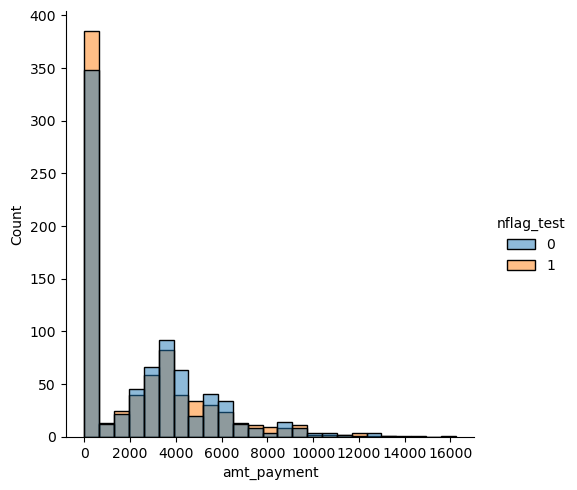

Гипотеза H0 подтверждается: средние равны
Разница средних = 0
Гиотеза H0 не подтверждается: средние не равны
Разница средних = 0.04931605920420967
Номер торговой точки =  72.0


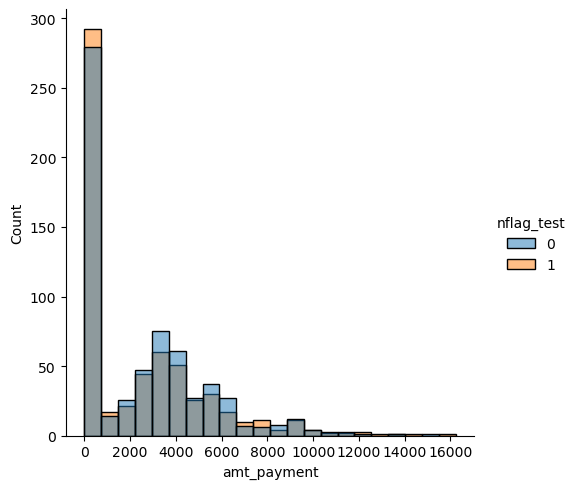

Номер торговой точки =  73.0


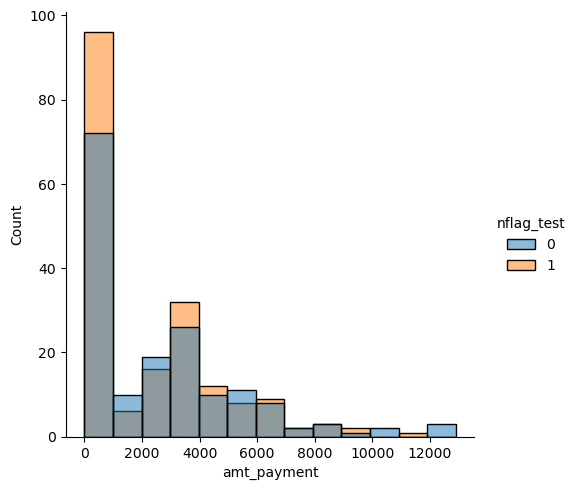

Волгоград



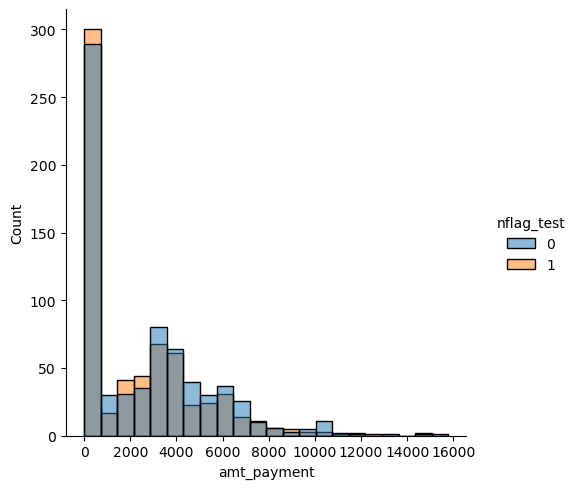

Гиотеза H0 не подтверждается: средние не равны
Разница средних = 312.89040013337035
Гипотеза H0 подтверждается: средние равны
Разница средних = 0
Номер торговой точки =  66.0


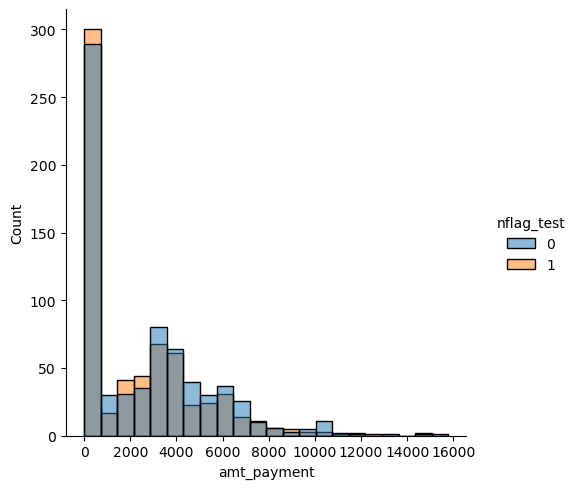

Ярославль



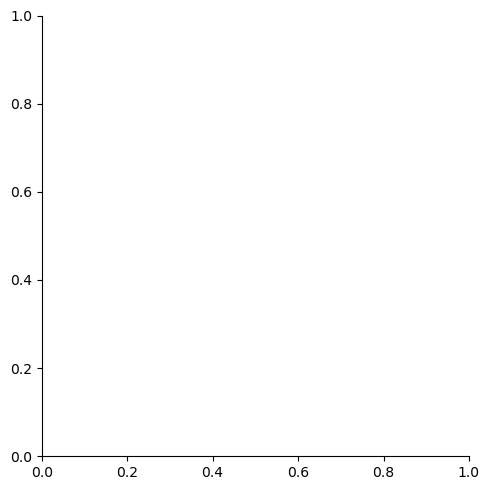

Гипотеза H0 подтверждается: средние равны
Разница средних = 0
Гипотеза H0 подтверждается: средние равны
Разница средних = 0
Тольятти



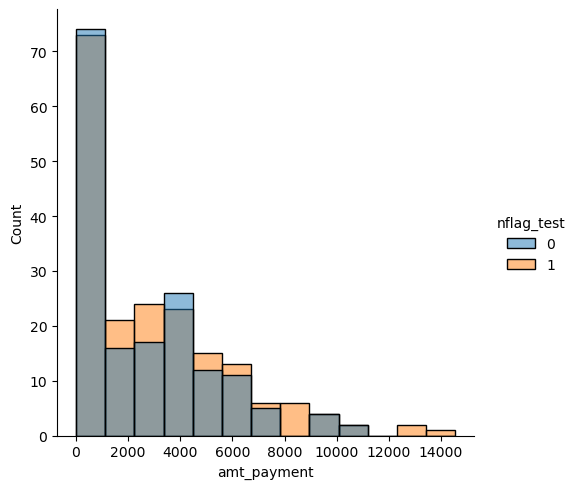

Гипотеза H0 подтверждается: средние равны
Разница средних = 0
Гипотеза H0 подтверждается: средние равны
Разница средних = 0
Номер торговой точки =  88.0


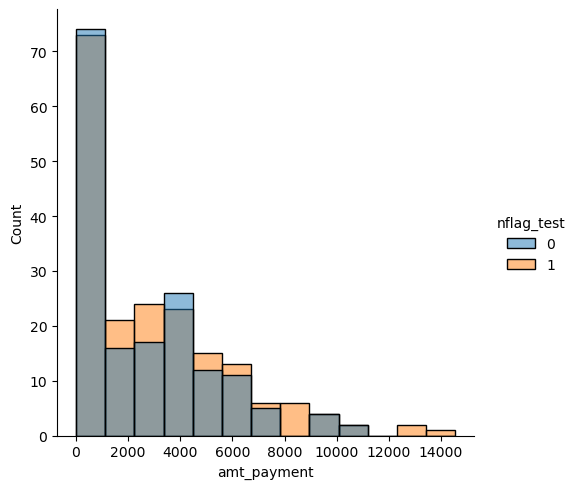

Тюмень



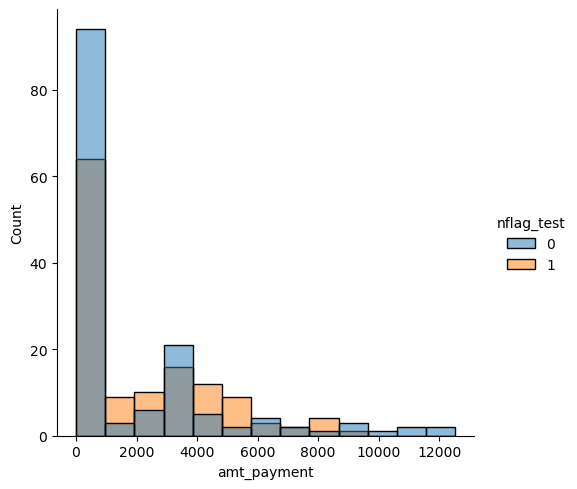

Гипотеза H0 подтверждается: средние равны
Разница средних = 0
Гиотеза H0 не подтверждается: средние не равны
Разница средних = -0.1463645943097998
Номер торговой точки =  19.0


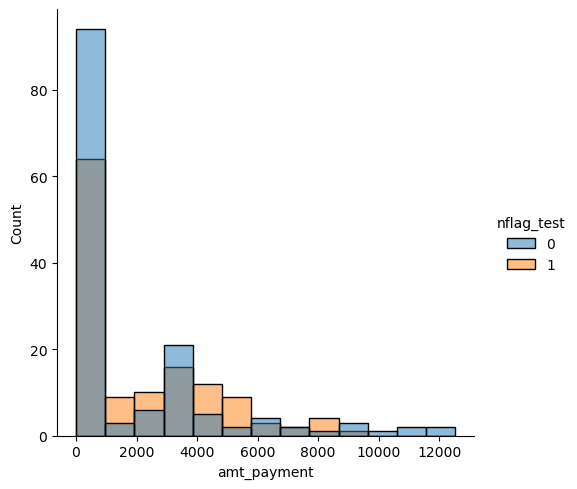

Дмитров



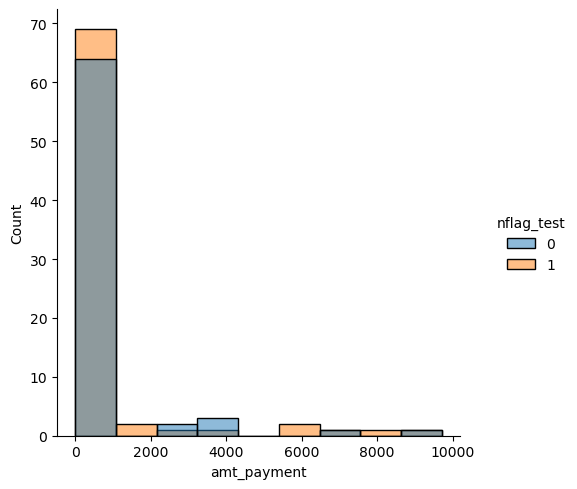

Гипотеза H0 подтверждается: средние равны
Разница средних = 0
Гипотеза H0 подтверждается: средние равны
Разница средних = 0
Номер торговой точки =  2.0


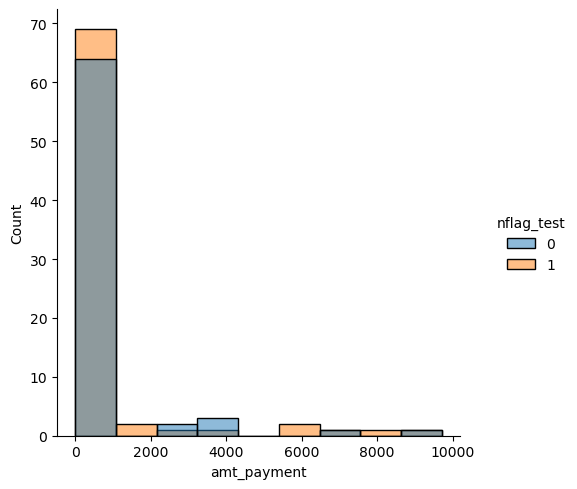

Сахалинск



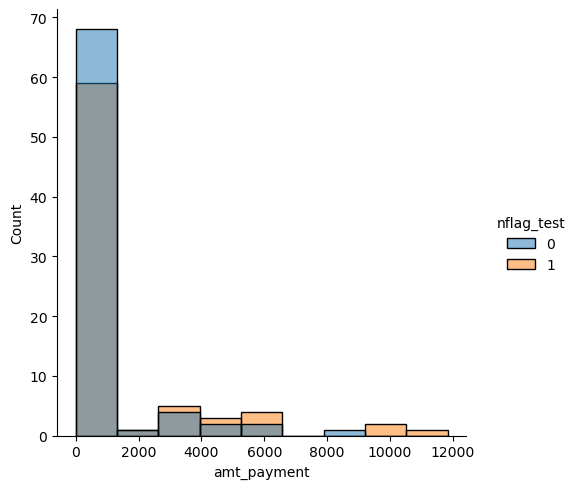

Гипотеза H0 подтверждается: средние равны
Разница средних = 0
Гипотеза H0 подтверждается: средние равны
Разница средних = 0
Номер торговой точки =  69.0


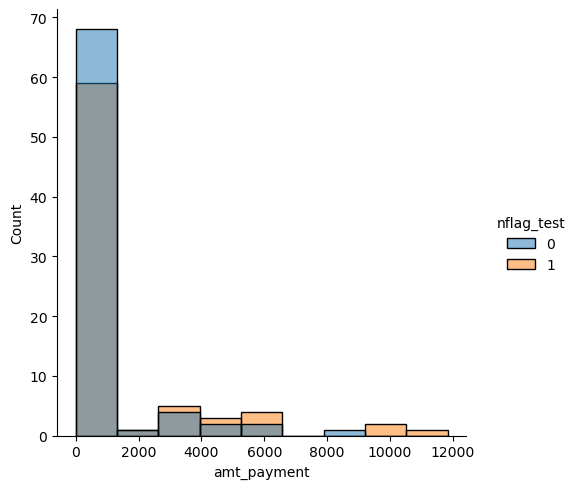

Ростов-на-Дону



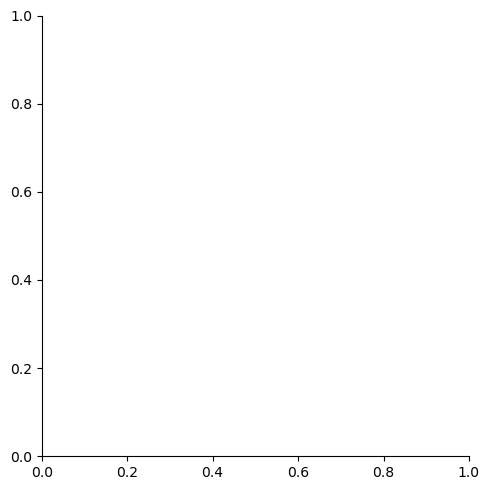

Гипотеза H0 подтверждается: средние равны
Разница средних = 0
Гипотеза H0 подтверждается: средние равны
Разница средних = 0
Ростов Великий



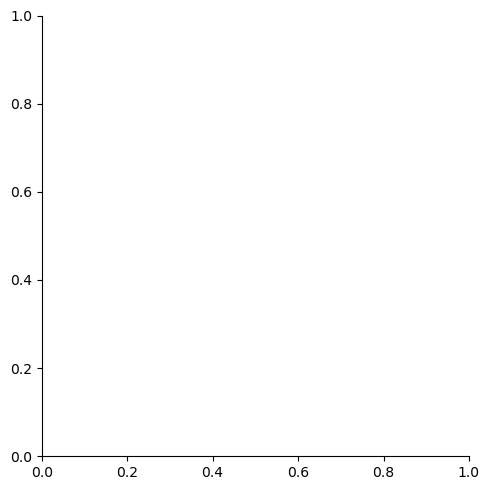

Гипотеза H0 подтверждается: средние равны
Разница средних = 0
Гипотеза H0 подтверждается: средние равны
Разница средних = 0
Великий Новгород



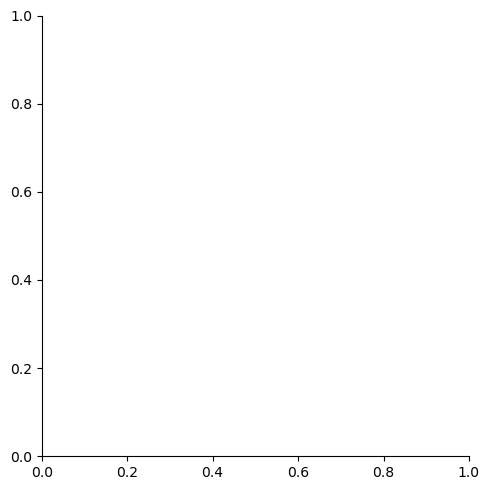

Гипотеза H0 подтверждается: средние равны
Разница средних = 0
Гипотеза H0 подтверждается: средние равны
Разница средних = 0
Чехов



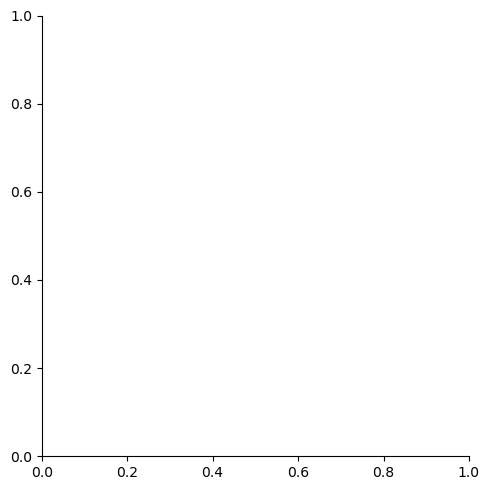

Гипотеза H0 подтверждается: средние равны
Разница средних = 0
Гипотеза H0 подтверждается: средние равны
Разница средних = 0
Петрозаводск



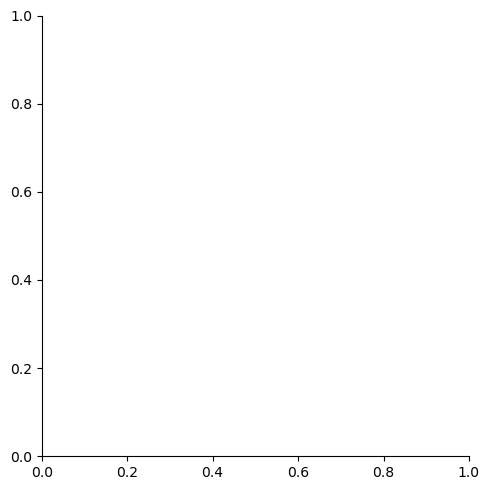

Гипотеза H0 подтверждается: средние равны
Разница средних = 0
Гипотеза H0 подтверждается: средние равны
Разница средних = 0
Нижний Новгород



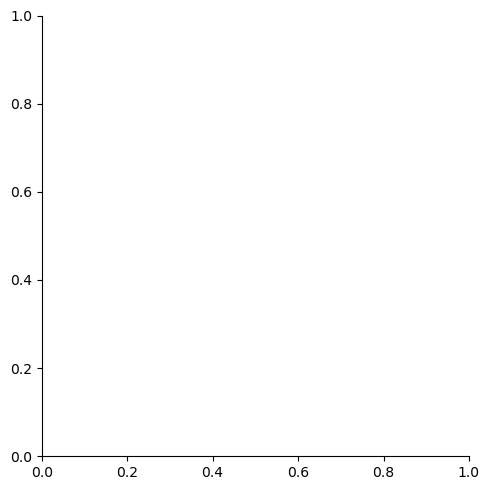

Гипотеза H0 подтверждается: средние равны
Разница средних = 0
Гипотеза H0 подтверждается: средние равны
Разница средних = 0


In [102]:
for i in other_cities:
    print(i)
    print()
    df_city = df_fin[df_fin['city']==i]
    
    sns.displot(df_city, x = 'amt_payment', hue = 'nflag_test')
    plt.show()
    
    test_calc(df_city[df_city['nflag_test']==0]['amt_payment'], df_city[df_city['nflag_test']==1]['amt_payment'])
    test_calc(df_city[df_city['nflag_test']==0]['nflag_paid'], df_city[df_city['nflag_test']==1]['nflag_paid'])
    
    for j in df_city['id_trading_point'].unique():
        df_loc = df_city[df_city['id_trading_point']==j]
        print("Номер торговой точки = ", j)
        sns.displot(df_loc, x = 'amt_payment', hue = 'nflag_test')
        plt.show()

In [ ]:
Отчет по АБ Тесту

In [108]:
df_result = pd.DataFrame()

for i in df_fin['city'].unique():
    df_loc = df_fin[df_fin['city']==i]
    
    for j in df_loc['id_trading_point'].unique():
        
        df_loc_f = df_loc[df_loc['id_trading_point']==j]
        
        count_test = len(df_loc_f[df_loc_f['nflag_test']==1])
        count_control = len(df_loc_f[df_loc_f['nflag_test']==0])
        count_all     = count_test + count_control
        sigma_test    = df_loc_f[df_loc_f['nflag_test']==1]['amt_payment'].std()
        sigma_control = df_loc_f[df_loc_f['nflag_test']==0]['amt_payment'].std()
        
        avg_test   = np.mean(df_loc_f[df_loc_f['nflag_test']==1]['amt_payment'])
        avg_control= np.mean(df_loc_f[df_loc_f['nflag_test']==0]['amt_payment'])
        diff       = avg_test - avg_control
        
        s_a, p_a = test_calc(df_loc_f[df_loc_f['nflag_test']==1]['amt_payment'], df_loc_f[df_loc_f['nflag_test']==0]['amt_payment'])
        s_p, p_p = test_calc(df_loc_f[df_loc_f['nflag_test']==1]['nflag_paid'], df_loc_f[df_loc_f['nflag_test']==0]['nflag_paid'])
        m_s, m_p = mann_whitney_func(df_loc_f[df_loc_f['nflag_test']==1]['amt_payment'], df_loc_f[df_loc_f['nflag_test']==0]['amt_payment'])
        
        df_result = df_result._append({'city':i
                                    , 'id_trading_point':j
                                    , 'count_test':count_test, 'count_control':count_control, 'count_all':count_all
                                    , 'avg_test':avg_test, 'avg_control':avg_control
                                    , 'sigma_test':sigma_test, 'sigma_control':sigma_control
                                    , 'diff':diff, 'abs_ttest_s':s_a, 'abs_ttest_p':p_a, 'pr_ttest_s':s_p}, ignore_index=True)
                                  
df_result['nflag_diff'] = np.where((df_result['abs_ttest_p'] < .05) & (df_result['diff'] > 0), 'Positive'
                                , np.where((df_result['abs_ttest_p'] < .05) & (df_result['diff'] < 0), 'Negative', 'No diff'))
df_result['percent_count'] = (df_result['count_all'] / df_result['count_all'].sum())                                  

Гиотеза H0 не подтверждается: средние не равны
Разница средних = 612.0424920007797
Гиотеза H0 не подтверждается: средние не равны
Разница средних = 0.11967888653001074
Распределения не равны
Гипотеза H0 подтверждается: средние равны
Разница средних = 0
Гиотеза H0 не подтверждается: средние не равны
Разница средних = 0.05984963486602768
Распределения не равны
Гиотеза H0 не подтверждается: средние не равны
Разница средних = 531.6059475298125
Гиотеза H0 не подтверждается: средние не равны
Разница средних = 0.10467325383304943
Распределения не равны
Гипотеза H0 подтверждается: средние равны
Разница средних = 0
Гипотеза H0 подтверждается: средние равны
Разница средних = 0
Распределения равны
Гипотеза H0 подтверждается: средние равны
Разница средних = 0
Гипотеза H0 подтверждается: средние равны
Разница средних = 0
Распределения равны
Гиотеза H0 не подтверждается: средние не равны
Разница средних = 761.1992559198145
Гиотеза H0 не подтверждается: средние не равны
Разница средних = 0.1416816212

In [137]:
df_result

,city,id_trading_point,count_test,count_control,count_all,avg_test,avg_control,sigma_test,sigma_control,diff,abs_ttest_s,abs_ttest_p,pr_ttest_s,nflag_diff,percent_count
0,Санкт-Петербург,453.0,1066,1049,2115,2501.966229,1889.923737,2993.442540,2648.659303,612.042492,4.976910,6.983207e-07,5.541076,Positive,0.046670
1,Санкт-Петербург,112.0,652,683,1335,2488.115031,2218.636896,2778.179183,2780.790660,269.478135,1.770712,7.683710e-02,2.197840,No diff,0.029458
2,Санкт-Петербург,117.0,625,587,1212,2582.297600,2050.691652,2835.004503,2595.737792,531.605948,3.398196,7.003817e-04,3.673055,Positive,0.026744
3,Санкт-Петербург,309.0,240,238,478,2706.279167,2392.894958,2814.939849,2761.938716,313.384209,1.228455,2.198834e-01,1.374431,No diff,0.010548
4,Санкт-Петербург,576.0,630,657,1287,1594.436508,1342.129376,2683.727211,2415.822664,252.307132,1.774073,7.628783e-02,1.535345,No diff,0.028399
5,Санкт-Петербург,900.0,335,341,676,2450.991045,1689.791789,2865.607356,2492.472611,761.199256,3.686914,2.452534e-04,3.718411,Positive,0.014917
6,Санкт-Петербург,213.0,232,255,487,2977.629310,2277.611765,2905.494362,2710.043413,700.017546,2.750752,6.168215e-03,2.524813,Positive,0.010746
7,Санкт-Петербург,801.0,225,212,437,2925.142222,2352.283019,2774.292063,2928.285838,572.859203,2.099991,3.630501e-02,2.475441,Positive,0.009643
8,Санкт-Петербург,573.0,177,160,337,2929.045198,1641.212500,3201.098137,2619.044781,1287.832698,4.016569,7.294074e-05,4.888660,Positive,0.007436
9,Санкт-Петербург,891.0,159,167,326,2618.949686,1980.658683,2899.782464,2489.571942,638.291003,2.135593,3.346204e-02,2.176540,Positive,0.007194


In [133]:
import xlsxwriter

In [147]:
writer = pd.ExcelWriter('Калькулятор АБ теста.xlsx', engine='xlsxwriter')

df_result[df_result['nflag_diff']=='Positive'].to_excel(writer, sheet_name='Успешные ТТ', index = False)
df_result[df_result['nflag_diff']=='Negative'].to_excel(writer, sheet_name='Неуспешные ТТ', index = False)
df_result[df_result['nflag_diff']=='No diff'].to_excel(writer, sheet_name='Нет разницы', index = False)

writer.close()